In [22]:
from geoarray import GeoArray
import matplotlib.pyplot as plt
import numpy as np

In [23]:
from isofit.utils import surface_model
from isofit.core.forward import ForwardModel
from isofit.configs.configs import create_new_config
from isofit.inversion.inverse import Inversion
from isofit.core.fileio import IO

In [24]:
import tkinter
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

In [25]:
"""
v2m2: India campaign, fourth draft calibration, campaign start, point-spread
      function (PSF) correction, new multiple endmember spectral mixture analysis
      (MESMA), new wavelengths, new RCCs, new methane (CH4) signatures for data
      collected from 20151218 through 20160308.
        
"""
# Data Gathered over Kurnool, India
data = GeoArray('C:\\Users\\vpatro\\Desktop\\ang20160126\\ang20160126t055327_corr_v2m2_img')
data_2015_Chilika = GeoArray('C:\\Users\\vpatro\\Desktop\\ang20151228\\ang20151228t060124_corr_v2m2_img')

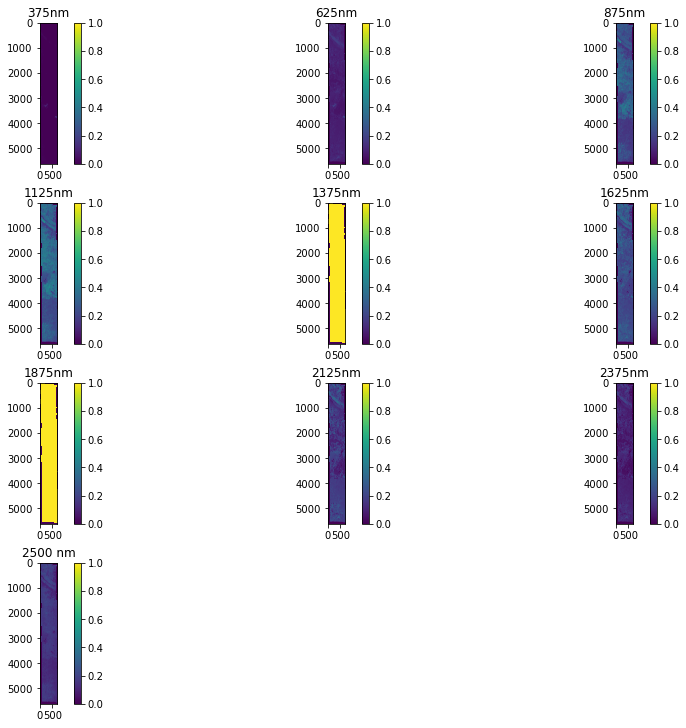

In [26]:
# Visualization of VSWIR -- entire image
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 375
channel = 0
for i in range(4):
    if i == 3:
        im = axs[i,0].imshow(data[:,:, 424])
        axs[i,0].set_title('2500 nm')
        plt.colorbar(im, ax = axs[i,0])
        im.set_clim(0,1)
        break
    for j in range(3):
        im = axs[i,j].imshow(data[:,:, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,1)
        wavelength += 250
        channel += 50
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
plt.show()

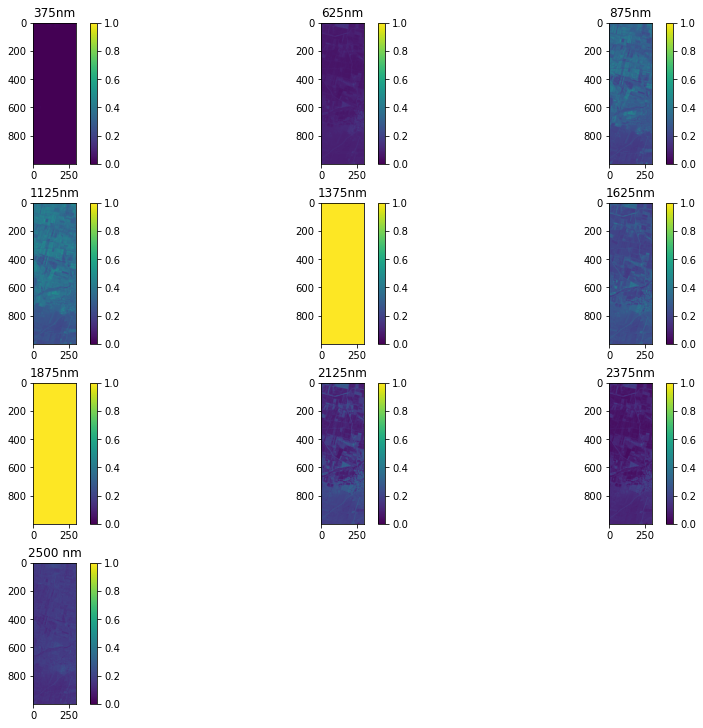

In [27]:
# Visualization of VSWIR -- zoomed in
fig, axs = plt.subplots(nrows = 4, ncols = 3, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 375
channel = 0
for i in range(4):
    if i == 3:
        im = axs[i,0].imshow(data[2000:3000,100:400, 424])
        axs[i,0].set_title('2500 nm')
        plt.colorbar(im, ax = axs[i,0])
        im.set_clim(0,1)
        break
    for j in range(3):
        im = axs[i,j].imshow(data[2000:3000,100:400, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,1)
        wavelength += 250
        channel += 50
fig.delaxes(axs[3,1])
fig.delaxes(axs[3,2])
plt.show()

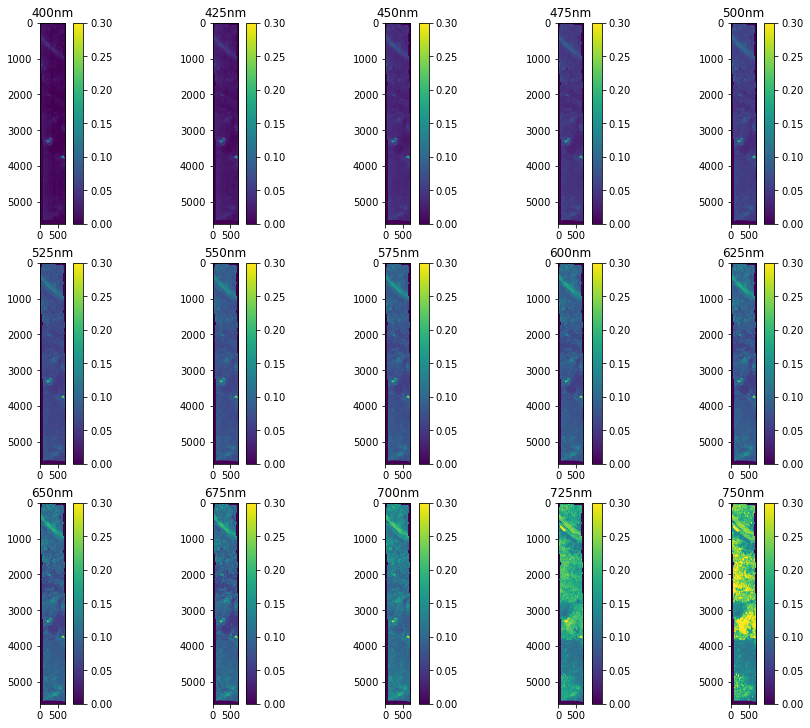

In [28]:
# Visualization of Visible Light spectrum -- entire image
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 400
channel = 5
for i in range(3):
    for j in range(5):
        im = axs[i,j].imshow(data[:,:, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,0.3)
        wavelength += 25
        channel += 5
plt.show()

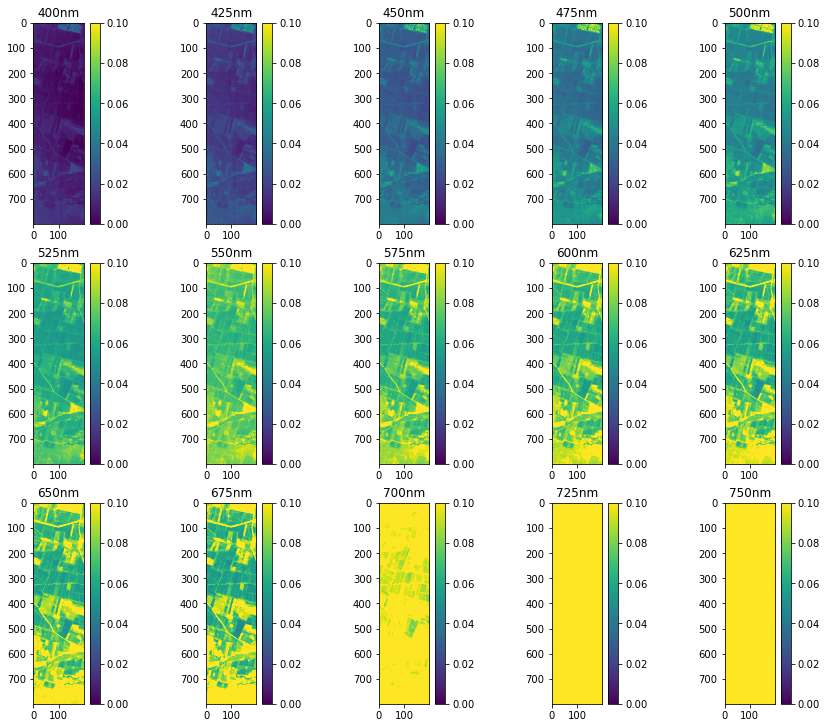

In [29]:
# Visualization of Visual Light spectrum -- zoomed in
fig, axs = plt.subplots(nrows = 3, ncols = 5, figsize = (12,10), constrained_layout = True)
gs = fig.add_gridspec()
wavelength = 400
channel = 5
for i in range(3):
    for j in range(5):
        im = axs[i,j].imshow(data[2000:2800,100:300, channel])
        axs[i,j].set_title(str(wavelength) + 'nm')
        plt.colorbar(im, ax = axs[i,j])
        im.set_clim(0,0.1)
        wavelength += 25
        channel += 5
plt.show()

In [30]:
# Sample pixel for experiment - Kurnool India
avirisng_input = data[200,500,:]

In [31]:
np.savetxt('C:\\Users\\vpatro\\Desktop\\avirisng_input.txt', avirisng_input)

In [32]:
# Surface model
surface_model("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_surface.json")


# Creating ISOFIT objects
config = create_new_config("C:\\Users\\vpatro\\Desktop\\isofit_vp\\examples\\20171108_Pasadena\\configs\\ang20171108t184227_beckmanlawn.json")
fm = ForwardModel(config)

x = np.loadtxt("C:\\Users\\vpatro\\Desktop\\avirisng_input.txt")
x = np.append(x,1.75)
x = np.append(x,0.05)

inv = Inversion(config, fm)
io = IO(config, fm)

io.get_components_at_index(0, 0)
geom = io.current_input_data.geom # alternately, call via geom = Geometry()...this won't have data from the above config file
meas = io.current_input_data.meas  # a numpy  array

In [33]:
OE_estimations = [[], [], [], [], []]
for i in range(5):
    radiance_measurement = fm.calc_rdn(x,geom)
    calculated_reflectance = inv.invert(radiance_measurement, geom)[0]
    OE_estimations[i] = calculated_reflectance

OE_estimations = np.array(OE_estimations)

assert(OE_estimations[0,:].all() == OE_estimations[1,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[2,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[3,:].all())
assert(OE_estimations[0,:].all() == OE_estimations[4,:].all())


np.savetxt(r'C:\Users\vpatro\\Desktop\OE_reflectance_estimation.txt', OE_estimations)

(0.0, 1.0)

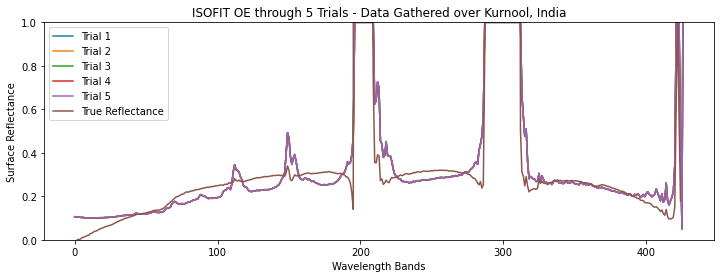

In [34]:
OE_estimated_reflectance = np.loadtxt(r'C:\Users\vpatro\\Desktop\OE_reflectance_estimation.txt')
labels = ['Trial 1', 'Trial 2', 'Trial 3', 'Trial 4', 'Trial 5']
plt.rcParams["figure.figsize"]=(12,4)
for i in range(OE_estimated_reflectance.shape[0]):
    column = OE_estimated_reflectance[i,:]
    plt.plot(column, label = labels[i])
    plt.title('ISOFIT OE through 5 Trials - Data Gathered over Kurnool, India')
plt.plot(avirisng_input, label = 'True Reflectance')
plt.legend()
plt.ylabel('Surface Reflectance')
plt.xlabel('Wavelength Bands')
plt.ylim(0,1)


In [35]:
# ISOFIT outputs should be the same
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[1,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[2,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[3,:].all())
assert(OE_estimated_reflectance[0,:].all() == OE_estimated_reflectance[4,:].all())